In [22]:
import serial
import time
import random
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.io as pio

In [23]:
import serial_interface as si

### Environment Class

In [24]:
test = '../../../rl_agent/simulation_data/data/corrected_motors/run_5_kitchen_no_lights.csv'

In [25]:
def load_and_prep_data(data_path):
    raw_df = pd.read_csv(data_path)
    data_df = raw_df.copy()
    # Make current positive
    data_df = data_df.drop_duplicates(subset=['motor_1_position','motor_2_position'])
    data_df['I_ivp_1'] = data_df['I_ivp_1'].abs()
    data_df['power'] = data_df['I_ivp_1'] * data_df['V_ivp_1']
    return data_df

In [61]:
def convert_motor_positions_to_index(motor_1_position, motor_2_position):
    return (int(motor_1_position//5), int(motor_2_position//5))

In [76]:
class SolarEnv:
    def __init__(self, reward_data_path):
        self.reward_array = np.zeros((37,37))
        # load in reward data
        rewards = load_and_prep_data(reward_data_path)
        for index, row in rewards.iterrows():
            motor_1_index = int(row['motor_1_position'].item()//5)
            motor_2_index = int(row['motor_2_position'].item()//5)
            position_reward = row['power'].item()
            self.reward_array[motor_1_index][motor_2_index] = position_reward
    
    # For debugging
    def get_reward_array(self):
        return self.reward_array
                                          
    # Not needed right now
    def env_init(self):
        """
        Setup for the environment called when the experiment first starts.
        """
        pass
    
    # Not needed right now
    def env_start(self):
        """
        The first method called when the experiment starts, called before the
        agent starts.

        Returns:
            The first state from the environment.
        """
        pass
    
    def env_step(self, action):
        """A step taken by the environment.

        Args:
            action: The action taken by the agent, a tuple of motor positions

        Returns:
            (float, state): a tuple of the reward, state
        """
        index_tuples = convert_motor_positions_to_index(action[0],action[1])
        return self.reward_array[index_tuples[0]][index_tuples[1]]

Visualizing the reward array

In [63]:
env = SolarEnv(test)
matrix = env.get_reward_array()

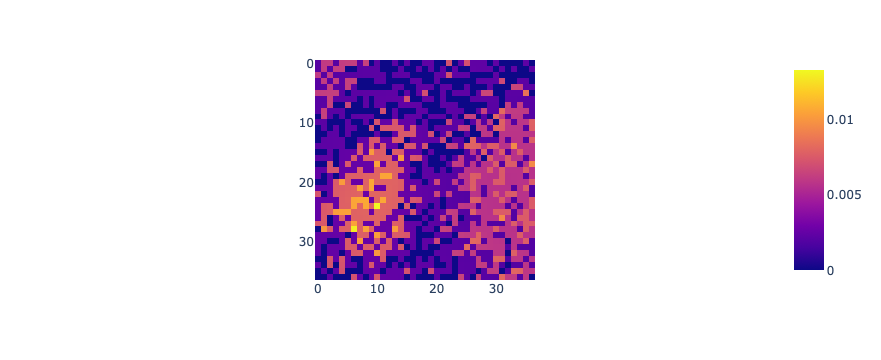

In [55]:
px.imshow(matrix)

### Agent Class

In [88]:
class SolarAgent:
    def __init__(self):
        self.step_size = 0.1
        self.epsilon = 0.05
        self.state_values = np.full((37,37), 10)
    
    def get_state_values(self):
        return self.state_values
    
    def agent_init(self):
        pass
    
    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            self.last_action [int] : The first action the agent takes.
        """
        pass
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward [float]: the reward received for taking the last action taken
            state [int]: the state from the environment's step, where the agent ended up after the last step
        Returns:
            self.last_action [int] : The action the agent is taking.
        """
        pass
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        pass

In [89]:
agent = SolarAgent()

In [90]:
print(agent.get_state_values())

[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


### Testing the Agent

----
----

In [7]:
# Request codes
MOTOR_CONTROL = 1000
STATE_REQUEST = 2000
RESET_CODE = 6666

def scan_space(arduino):
    # Run start
    run_start = time.time()
    data_dict_list = []
    last_motor_interval = 0
    last_measure_interval = -1
    motor_frequency = 2
    measure_frequency = 1
    # Set timeouts
    abort = False
    
    for xy_degree in range(0, 181, 5):
        for yz_degree in range(0, 181, 5):
            si.write_serial_line(arduino, [MOTOR_CONTROL, xy_degree, yz_degree], print_message=False)
            new_message, abort = si.listen_for_serial(arduino)
            if new_message is not None and not abort:
                data_dict_list.append(new_message)
            elif abort:
                break
            else:
                print('Empty message received without abort issue')
            time.sleep(0.1) # Wait for steady state
        if abort:
            break
        print('xy:',xy_degree,'yz:',yz_degree)
    # Write back to start state
    write_serial_line(arduino, [si.MOTOR_CONTROL, 90, 90])

    return pd.DataFrame(data_dict_list)

In [8]:
if __name__ == '__main__':
    print('\nARDUINO CONTROL TESTING')
    print('-------------------------')
    # Initialize serial port
    print('\nIniitalizing device...')
    serial_port = '/dev/cu.usbmodem14101'
    baud_rate = 9600
    timeout = 5
    arduino = si.initialize_serial(serial_port=serial_port, baud_rate=baud_rate, timeout=timeout)
    print('\t - SUCCESS: Device initialized.')
    
    si.write_serial_line(arduino, [MOTOR_CONTROL, 90, 90])

    # Run a loop where motor position incremented every 5 seconds, print out message
    print('\nBeginning loop sequence...')
#     data = scan_space(arduino)
    print('\t - Loop complete.')

    # Add relative time to returned data and print out
#     data['t_relative'] = data['timestamp'] - data['timestamp'].iloc[0]
    print('\nData broadcasted by Arduino:\n')
    
#     data.to_csv('/Users/jackogrady/Git/rl-solar/rl_agent/simulation_data/data/run_6_kitchen_no_lights_swapped_motors.csv', index=False)


ARDUINO CONTROL TESTING
-------------------------

Iniitalizing device...


SerialException: [Errno 2] could not open port /dev/cu.usbmodem14101: [Errno 2] No such file or directory: '/dev/cu.usbmodem14101'

In [51]:
print(data)

         timestamp state arduino_duration motor_1_position motor_2_position  \
0     1.636041e+09  1111          143.785               90               90   
1     1.636041e+09  1111            2.093                0                0   
2     1.636041e+09  1111            0.337                0                5   
3     1.636041e+09  1111            0.339                0               10   
4     1.636041e+09  1111            0.339                0               15   
...            ...   ...              ...              ...              ...   
1364  1.636041e+09  1111            0.342              180              155   
1365  1.636041e+09  1111            0.343              180              160   
1366  1.636041e+09  1111            0.342              180              165   
1367  1.636041e+09  1111            0.342              180              170   
1368  1.636041e+09  1111            0.342              180              175   

     I_ivp_1 V_ivp_1 P_ivp_1  t_relative  
0      0

In [57]:
write_serial_line(arduino, [1000, 180, 90])

Writing serial message: [1000, 180, 90]


True